## Methods to compare in integration tasks

Harmony and Liger are widely-used data integration / batch effect correction methods that have Python implementations. Harmony is usually considered to be less aggressive in strength, thus keeping more biological variance. Liger is suitable in situations with more severe batch effect.

In [1]:
import os

import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import numpy as np

In [4]:
import scanpy as sc

In [5]:
import harmonypy as hm
import pyliger
import scanorama

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


## Load data and view the data without integration

In [6]:
adata = sc.read_h5ad("../../mouse-brain/merfish.h5ad")

In [11]:
adata

AnnData object with n_obs × n_vars = 378918 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'donor_slice'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'batch_condition', 'cell_type_colors', 'schema_version', 'title', 'donor_slice_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'spatial'
    obsp: 'distances', 'connectivities'

In [7]:
adata.obs['donor_slice'] = adata.obs['donor_id'].astype(str) + '_' + adata.obs['slice'].astype(str)

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\pandas\core\arrays\categorical.py:568: RuntimeWarning: invalid value encountered in cast
C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\pandas\core\arrays\categorical.py:568: RuntimeWarning: invalid value encountered in cast


In [14]:
batch = 'donor_slice'

... storing 'donor_slice' as categorical


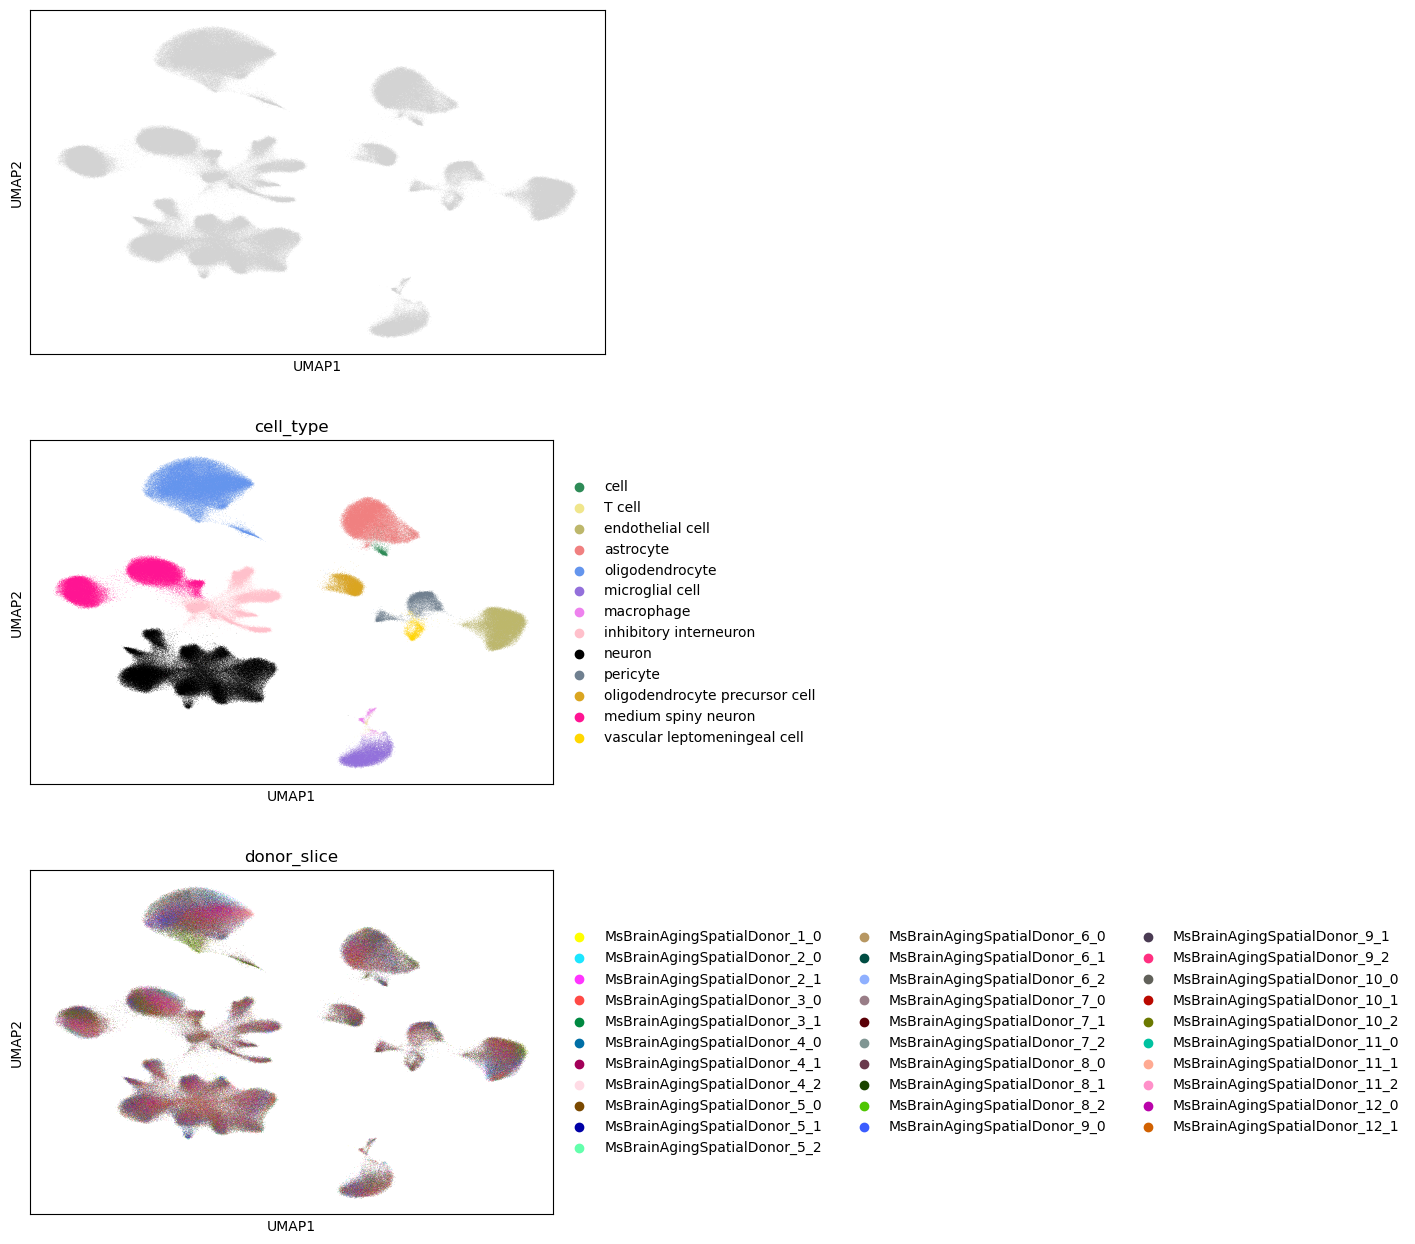

In [8]:
%matplotlib inline
sc.pl.umap(adata, color=[None, 'cell_type', 'donor_slice'], ncols=1)
pass

## PCA (w/o correction)

In [9]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

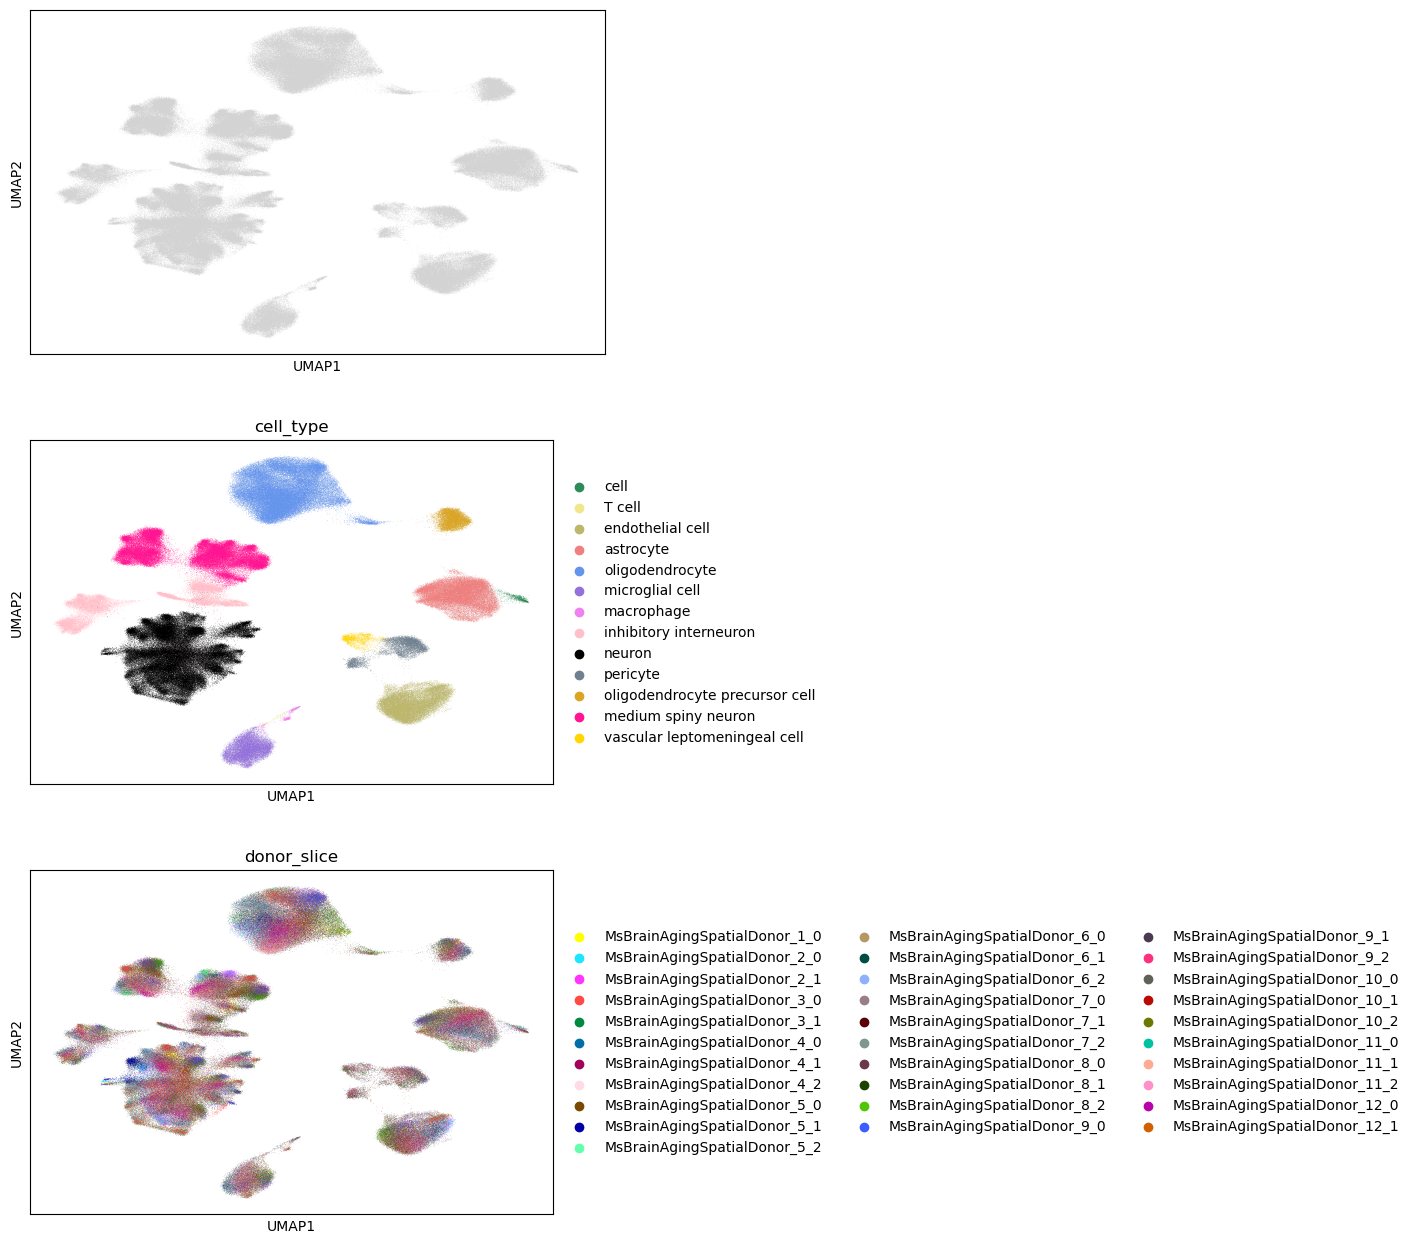

In [10]:
%matplotlib inline
sc.pl.umap(adata, color=[None, 'cell_type', 'donor_slice'], ncols=1)
pass

## Harmony integration

In [15]:
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs[[batch]], [batch])

2023-10-04 10:18:57,955 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2023-10-04 10:20:55,772 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2023-10-04 10:20:57,679 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2023-10-04 10:24:18,265 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2023-10-04 10:27:06,395 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2023-10-04 10:28:32,114 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2023-10-04 10:29:51,041 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


In [16]:
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
adata.obsm['X_harmony'] = res.to_numpy().T

In [17]:
sc.pp.neighbors(adata, use_rep='X_harmony')
sc.tl.umap(adata)

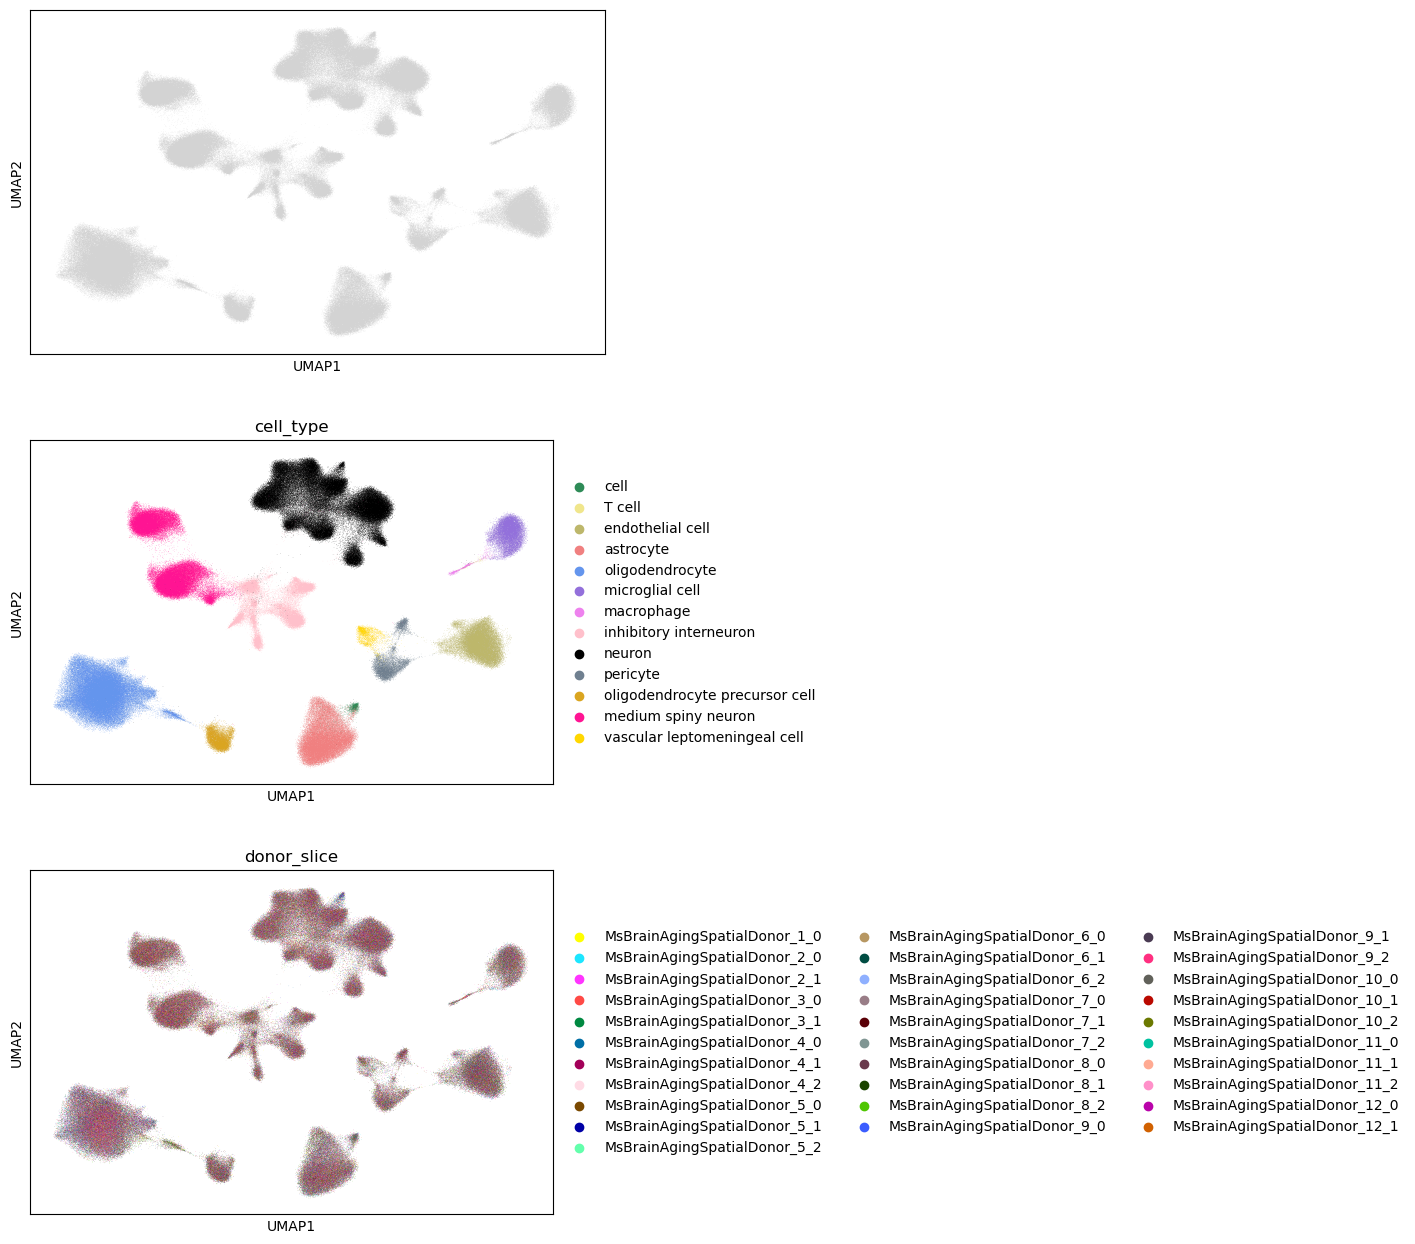

In [18]:
%matplotlib inline
sc.pl.umap(adata, color=[None, 'cell_type', batch], ncols=1)
pass

## Liger

In [19]:
adatas = []
for i in adata.obs['donor_slice'].unique():
    adatas.append(adata.raw.to_adata()[adata.obs['donor_slice'] == i, :])
    adatas[-1].obs.index.name = 'cell_names'
    adatas[-1].var.index.name = 'gene_names'
    adatas[-1].uns['sample_name'] = i
    
liger = pyliger.create_liger(adatas)

In [20]:
pyliger.normalize(liger)
pyliger.select_genes(liger)
pyliger.scale_not_center(liger)
pyliger.optimize_ALS(liger, k = 20)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [14:20<00:00, 28.69s/it]


In [21]:
pyliger.quantile_norm(liger)

In [22]:
adata.obsm['X_liger'] = np.vstack([adata.obsm["H_norm"] for adata in liger.adata_list])

In [23]:
sc.pp.neighbors(adata, use_rep='X_liger', metric='cosine')
sc.tl.umap(adata)

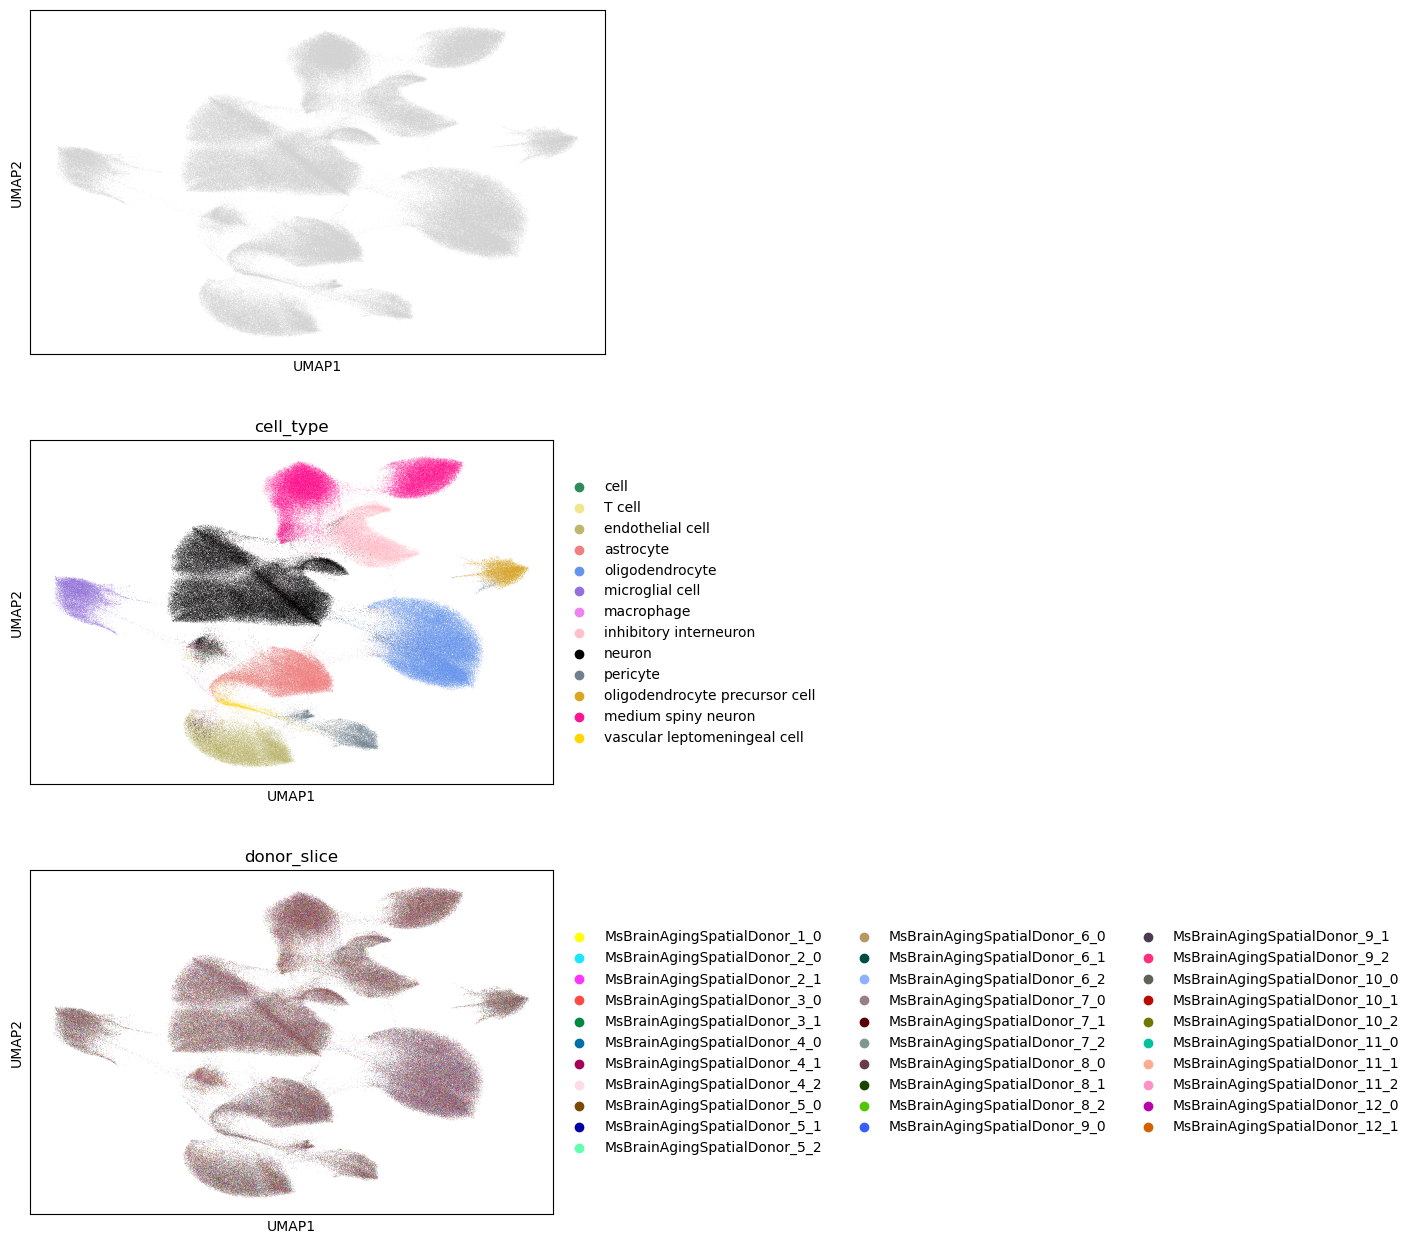

In [25]:
%matplotlib inline
sc.pl.umap(adata, color=[None, 'cell_type', 'donor_slice'], ncols=1)
pass

## Scanorama

In [26]:
adatas = []
for i in adata.obs['donor_slice'].unique():
    adatas.append(adata.raw.to_adata()[adata.obs['donor_slice'] == i, :])
    adatas[-1].obs.index.name = 'cell_names'
    adatas[-1].var.index.name = 'gene_names'
    adatas[-1].uns['sample_name'] = i
    

In [27]:
corrected = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 374 genes among all datasets
[[0.         0.14130698 0.08085893 0.24608685 0.16792288 0.40680728
  0.28420569 0.29046077 0.05873045 0.03450963 0.07175446 0.09701966
  0.06234689 0.05566961 0.20784348 0.18550287 0.17477979 0.14849172
  0.11855501 0.0981223  0.09115699 0.08211899 0.0780034  0.163373
  0.09743163 0.09577241 0.07740225 0.05656921 0.05336105 0.12879654
  0.11220934]
 [0.         0.         0.69179304 0.17558697 0.10880377 0.10582058
  0.09017447 0.04231533 0.31915488 0.26906379 0.18301535 0.05421687
  0.05230279 0.04468059 0.10335147 0.07201433 0.08011127 0.04893075
  0.0272578  0.02110336 0.03067783 0.02584333 0.01789069 0.07604759
  0.04398461 0.04352261 0.13969516 0.11292709 0.1027027  0.0744059
  0.08404274]
 [0.         0.         0.         0.14794244 0.11042437 0.08527202
  0.06932966 0.03259847 0.2969099  0.24078816 0.2040647  0.04692454
  0.04054385 0.03803888 0.06009826 0.05042888 0.05266574 0.02471321
  0.0183908  0.01819541 0.01480327 0.01521617 0.01395474

Processing datasets (1, 2)
Processing datasets (12, 13)
Processing datasets (20, 21)
Processing datasets (21, 22)
Processing datasets (11, 12)
Processing datasets (11, 13)
Processing datasets (17, 19)
Processing datasets (8, 10)
Processing datasets (18, 19)
Processing datasets (8, 9)
Processing datasets (20, 22)
Processing datasets (5, 6)
Processing datasets (17, 18)
Processing datasets (23, 25)
Processing datasets (9, 10)
Processing datasets (24, 25)
Processing datasets (29, 30)
Processing datasets (0, 5)
Processing datasets (26, 27)
Processing datasets (4, 5)
Processing datasets (27, 28)
Processing datasets (6, 7)
Processing datasets (23, 24)
Processing datasets (4, 11)
Processing datasets (19, 20)
Processing datasets (19, 21)
Processing datasets (5, 7)
Processing datasets (4, 12)
Processing datasets (1, 8)
Processing datasets (14, 16)
Processing datasets (2, 8)
Processing datasets (14, 15)
Processing datasets (0, 7)
Processing datasets (17, 20)
Processing datasets (22, 25)
Processin

In [28]:
adata.obsm['X_scanorama'] = np.vstack([corrected[i].obsm['X_scanorama'] for i in range(len(adatas))])

In [30]:
sc.pp.neighbors(adata, use_rep='X_scanorama', metric='cosine')
sc.tl.umap(adata)

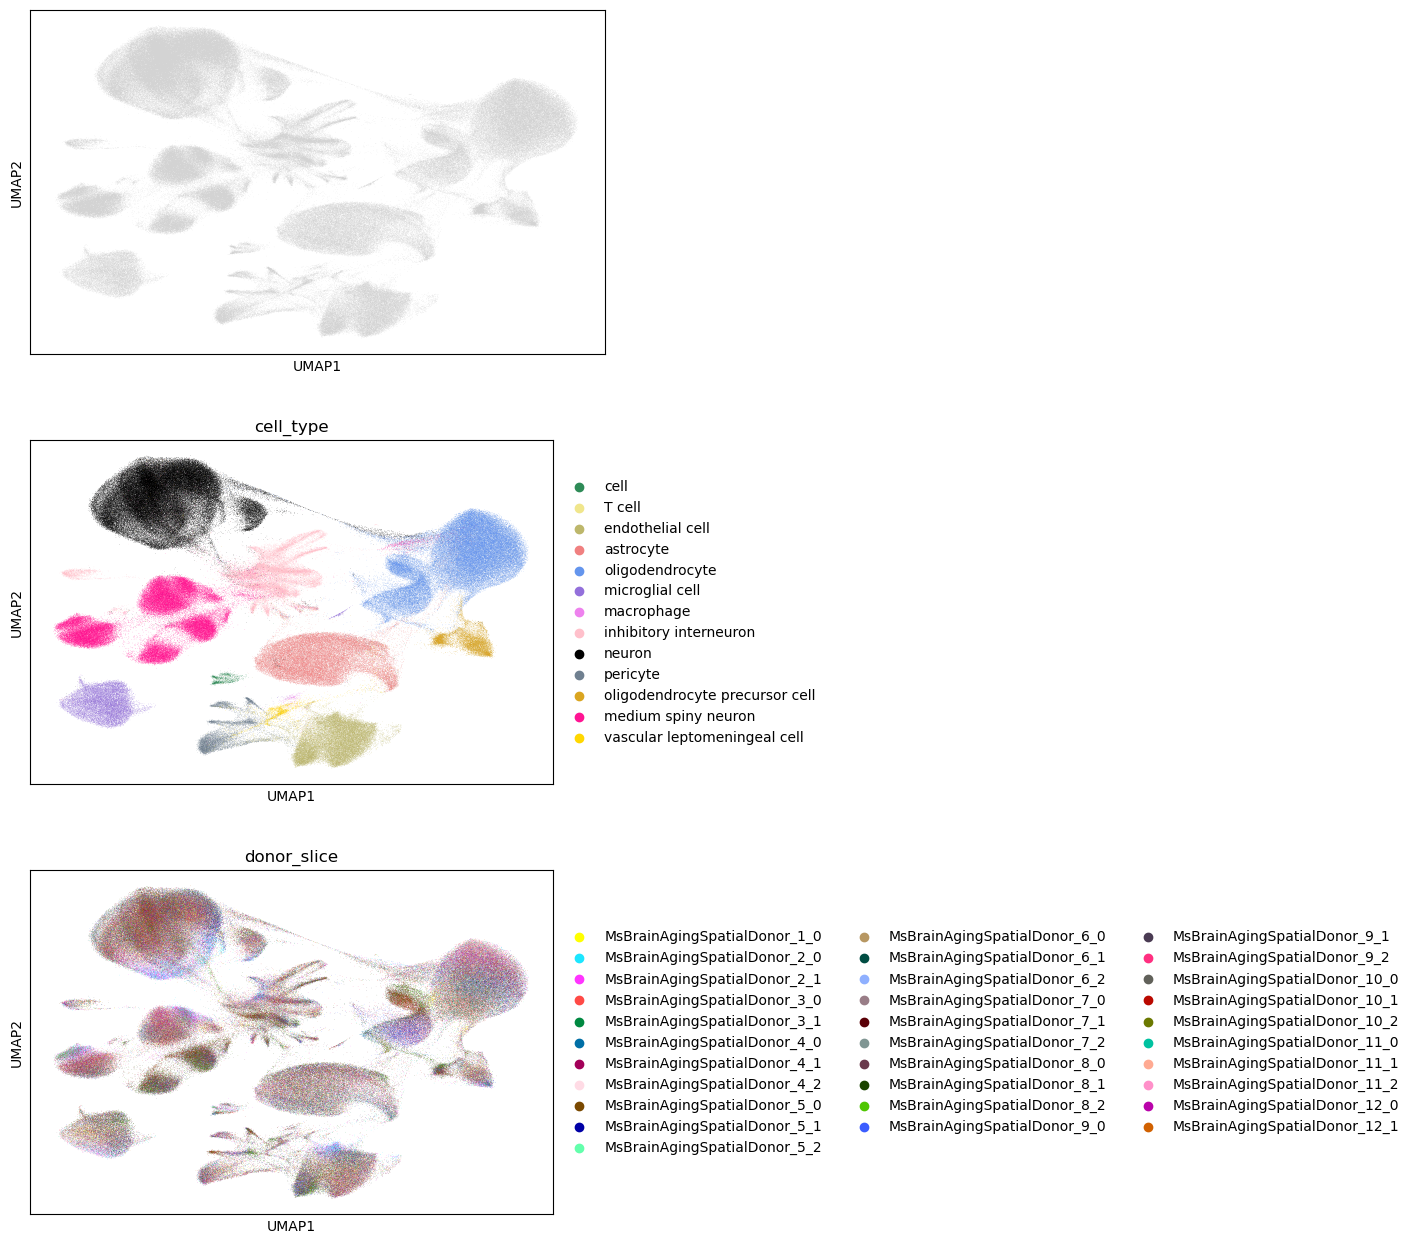

In [32]:
%matplotlib inline
sc.pl.umap(adata, color=[None, 'cell_type', 'donor_slice'], ncols=1)
pass

## Scoring and plotting 

In [29]:
adata.write("output/mouse-brain-374-integration.h5ad")